# Imports and Inputs

In [49]:
from collections import Counter, defaultdict
import itertools
import matplotlib.pyplot as plt
from typing import List

plate_size = 96
samples = [['Sam 1', 'Sam 2', 'Sam 3'], ['Sam 1', 'Sam 3', 'Sam 4']]
reagents = [['Reag X', 'Reag Y'], ['Reag Y', 'Reag Z','Reag A', 'Reag B', 'Reag C']]
replicas = [16, 6]
well_num = 12

# Helper functions and common classes

In [50]:
def not_enough_plates(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[int]:
    wells_available = plate_size * well_num
    wells_needed = 0
    experiment_count = len(replicas)
    for experiment_number in range(experiment_count):
        wells_needed += len(samples[experiment_number]) * len(reagents[experiment_number]) * replicas[experiment_number]
    
    if wells_needed > wells_available:
        return [1, wells_needed, wells_available]
    else:
        return [0, wells_needed, wells_available]

def flip_even_rows(plate: List[List[str]]) -> None:
    for i, row in enumerate(plate):
        if i % 2:
            plate[i] = row[::-1]
    
class PlateFillError(Exception):
    def __init__(self, message):
        self.message = message
        super().__init__(self.message)

def evaluate_microplate(plates):
    penalty = 0
    for plate in plates:
        flip_even_rows(plate)
        previous_sample, previous_reagent = plate[0][0]
        for row in plate:
            for well in row:
                if any(well):
                    current_sample, current_reagent = well
                    if current_sample != previous_sample:
                        penalty += 1
                        previous_sample = current_sample
                    if current_reagent != previous_reagent:
                        penalty += 1
                        previous_reagent = current_reagent

    return penalty

# Visualize the resulting plates

In [51]:
def plot_plate(plate, color_map, color_by, plate_index):
    _, ax = plt.subplots(figsize=(12, 8))

    title_text = f"Colored by {color_by.capitalize()}"
    if plate_index is not None:
        title_text += f" | Plate Index: {plate_index}"

    plt.title(title_text)

    for i, row in enumerate(plate):
        for j, well in enumerate(row):
            if well and all(w is not None for w in well):
                item_to_color = well[0] if color_by == 'sample' else well[1]

                if item_to_color not in color_map:
                    color_map[item_to_color] = next(color_cycle)

                ax.text(j, i, f"{well[0]}\n{well[1]}", ha='center', va='center', fontsize=12, color='black')
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor=color_map[item_to_color], edgecolor='black', linewidth=2))
            else:
                ax.add_patch(plt.Rectangle((j-0.5, i-0.5), 1, 1, facecolor='white', edgecolor='black', linewidth=2))

    if plate_size == 96:
        number_of_rows = 8
        number_of_columns = 12
    elif plate_size == 384:
        number_of_rows = 16
        number_of_columns = 24

    row_labels = [chr(i) for i in range(ord('A'), ord('A') + number_of_rows)]
    col_labels = [i + 1 for i in range(number_of_columns)]

    for i, label in enumerate(row_labels):
        ax.text(-1, i, label, ha='center', va='center', fontsize=12, color='black')

    for j, label in enumerate(col_labels):
        ax.text(j, -1, str(label), ha='center', va='center', fontsize=12, color='black')

    ax.set_xlim(-0.5, len(plate[0])-0.5)
    ax.set_ylim(-0.5, len(plate)-0.5)
    ax.set_aspect('equal', 'box')
    plt.gca().invert_yaxis()
    plt.axis('off')
    plt.show()


# The filling algorithm should do a few things.

1. There are two possible sizes of microtiter plates 96-well (12x8) and 384-well (24x16) - return an error if there is overflow.
2. Keep experiments grouped as much as possible - within experiments group samples and reagents

# #1 Naive approach - greedily fill the plates and only group reagents and specimen that repeat within experiments.
The plates will be represented as 12x8 or 24x16 matrix depending on the input and the cells will be filled iteratively experiment by experiment.
The plate will be filled row by row from left to right and will be added to a result list once it is filled or all experiments are placed in the wells.

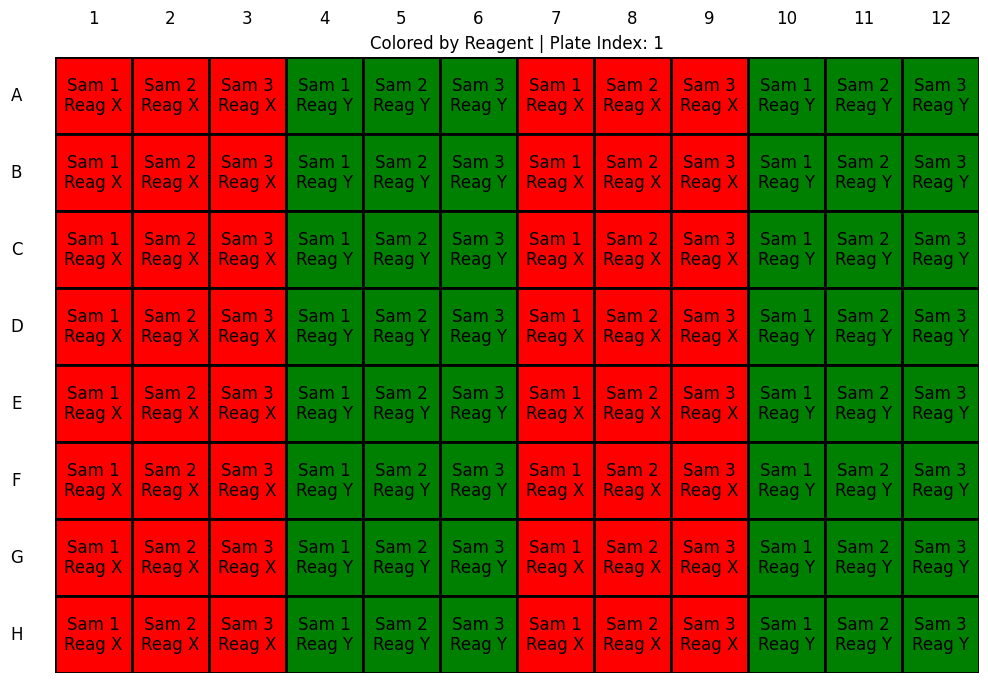

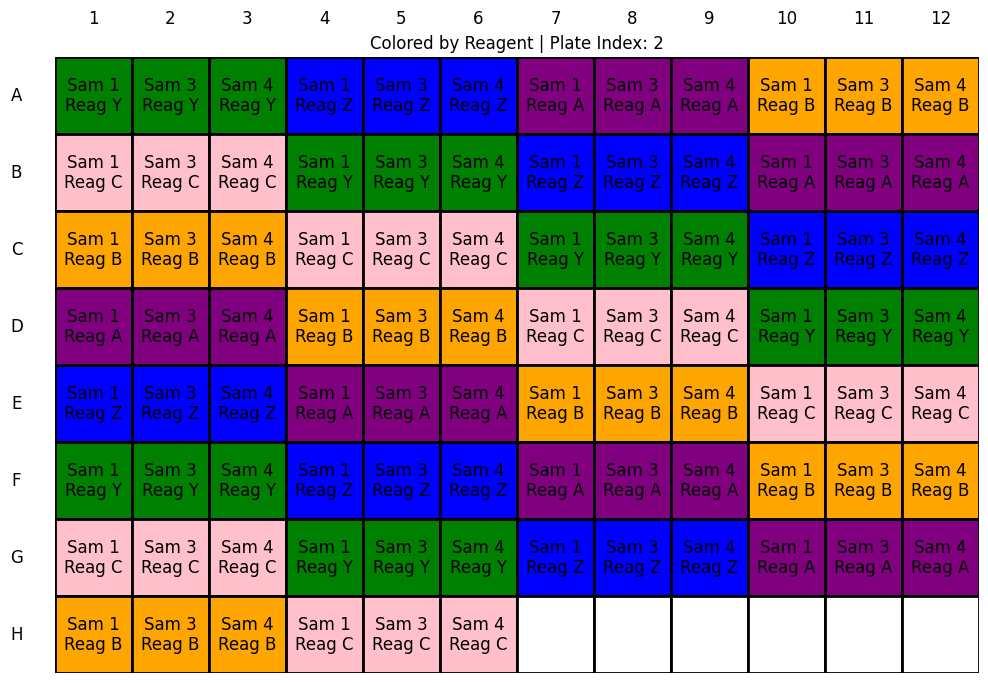

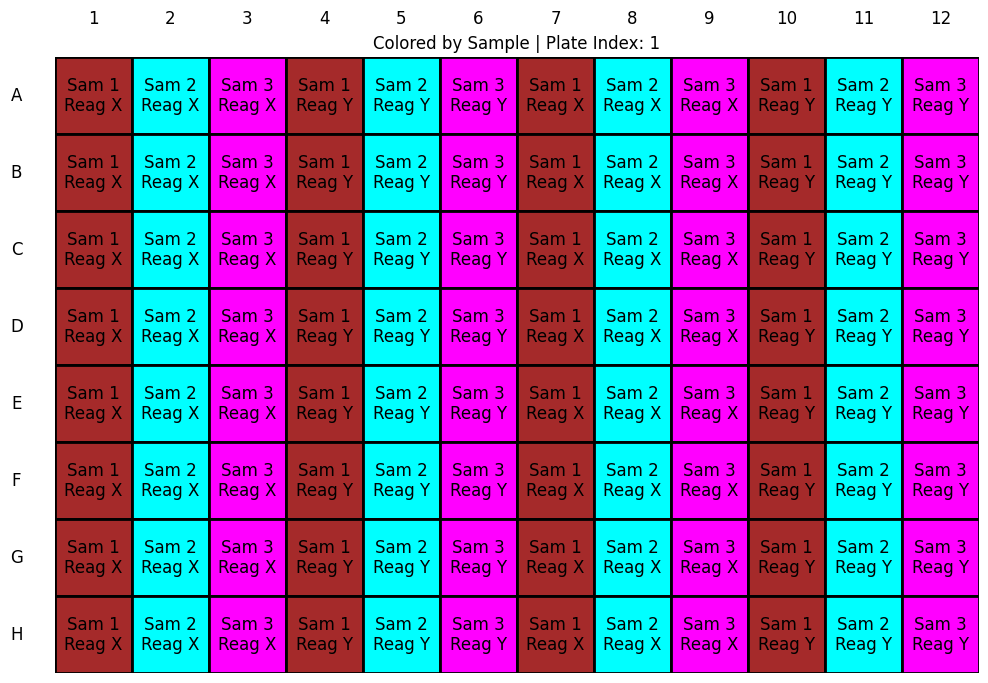

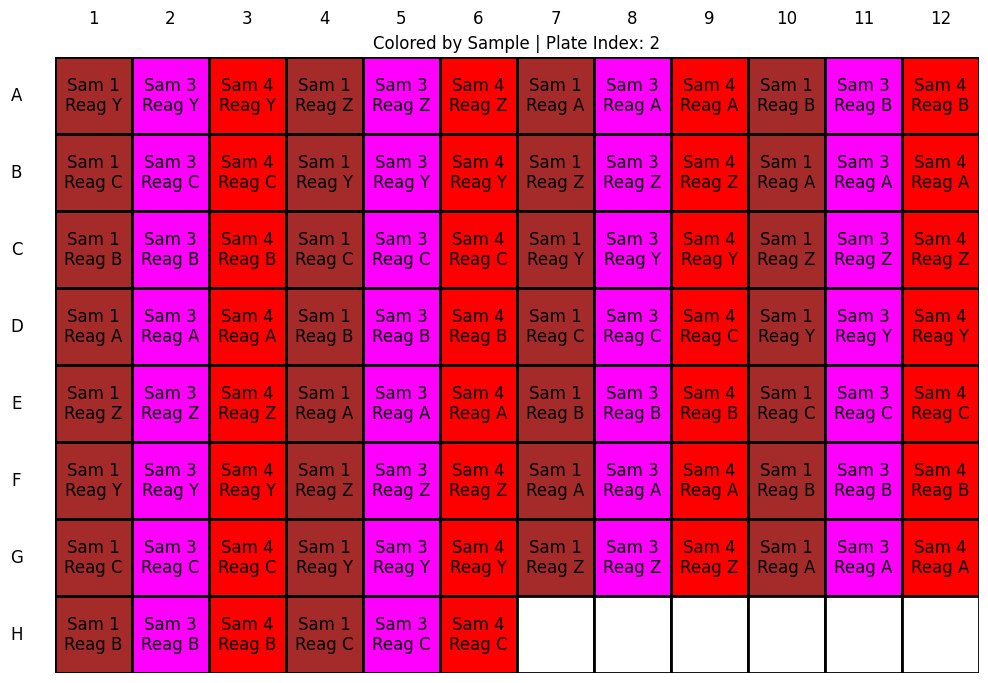

In [52]:
def greedy_fill(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[List[List[str]]]:
    not_enough, wells_needed, wells_available = not_enough_plates(plate_size, samples, reagents, replicas, well_num)
    if not_enough:
        error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
        raise PlateFillError(error_message)

    if plate_size == 96:
        num_rows = 8
        num_cols = 12
    elif plate_size == 384:
        num_rows = 16
        num_cols = 24

    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
    result = []

    current_well = 0
    experiment_count = len(replicas)

    for experiment_number in range(experiment_count):
        experiment_samples = samples[experiment_number]
        experiment_reagents = reagents[experiment_number]
        experiment_replicas = replicas[experiment_number]

        for replica in range(experiment_replicas):
            for reagent in experiment_reagents:
                for sample in experiment_samples:
                    if current_well == plate_size:
                        result.append(plate)
                        plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
                        current_well = 0

                    row_index = current_well // num_cols
                    col_index = current_well % num_cols

                    plate[row_index][col_index] = [sample, reagent]

                    current_well += 1

    if plate:
        result.append(plate)

    return result

try:
    plates = greedy_fill(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")

colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}
    
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='reagent', plate_index=i)
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='sample', plate_index=i)
    # plt.savefig(f'Plate_{i}.png')


The naive approach didn't turn out amazing even in the most simple of cases. Therefore I will try to implement a different approach. I will not group the wells by experiment, but rather I will group them by reagents and sample combination counts and will plot them like this. This approach is only slightly more advanced, but should still be fairly naive to implement.

# Approach #2 - Group reagents and samples globally and store them in a hashmap. Place reagents by frequeny and samples within each reagent group by name.
This way we can get an efficient schema of the reagents and their coresponding samples.

Another way to possibly reduce the movement needed is to reverse the order of every even indexed row, I could imagine it helps.

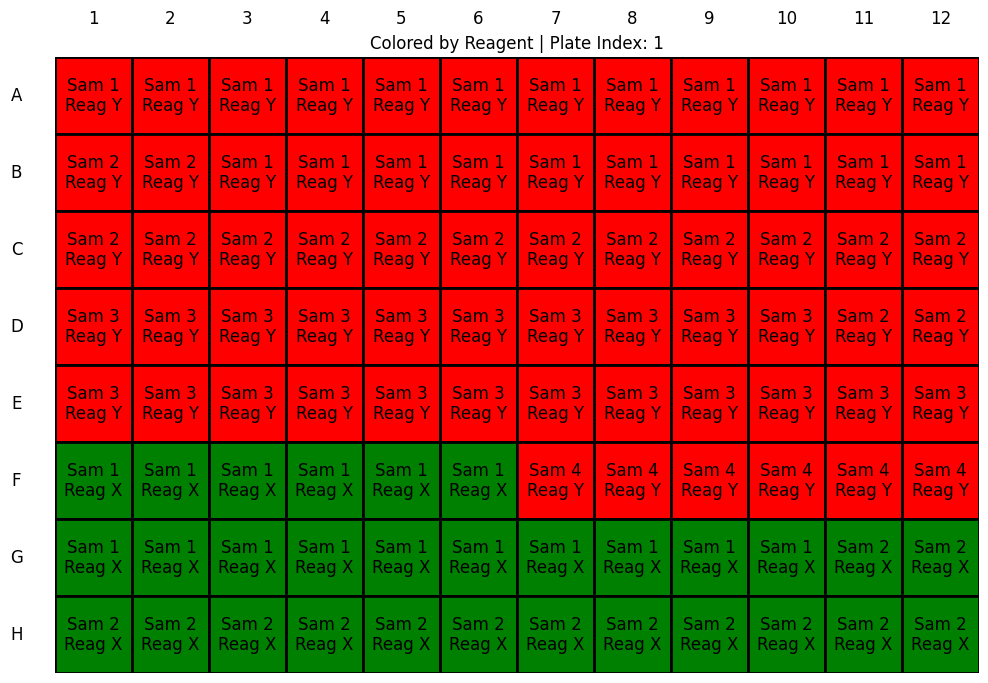

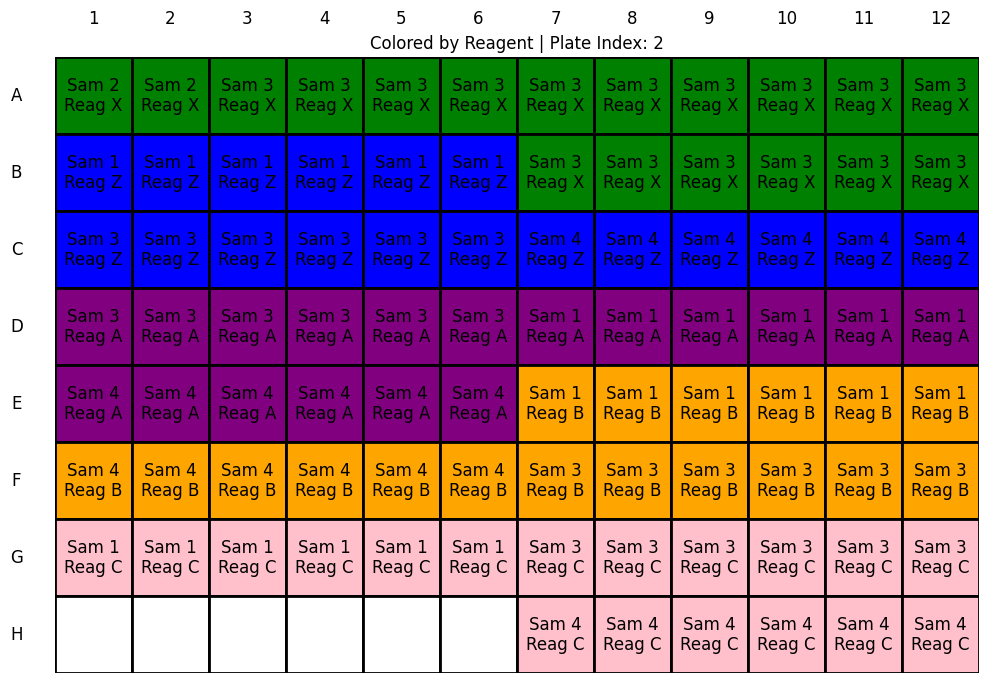

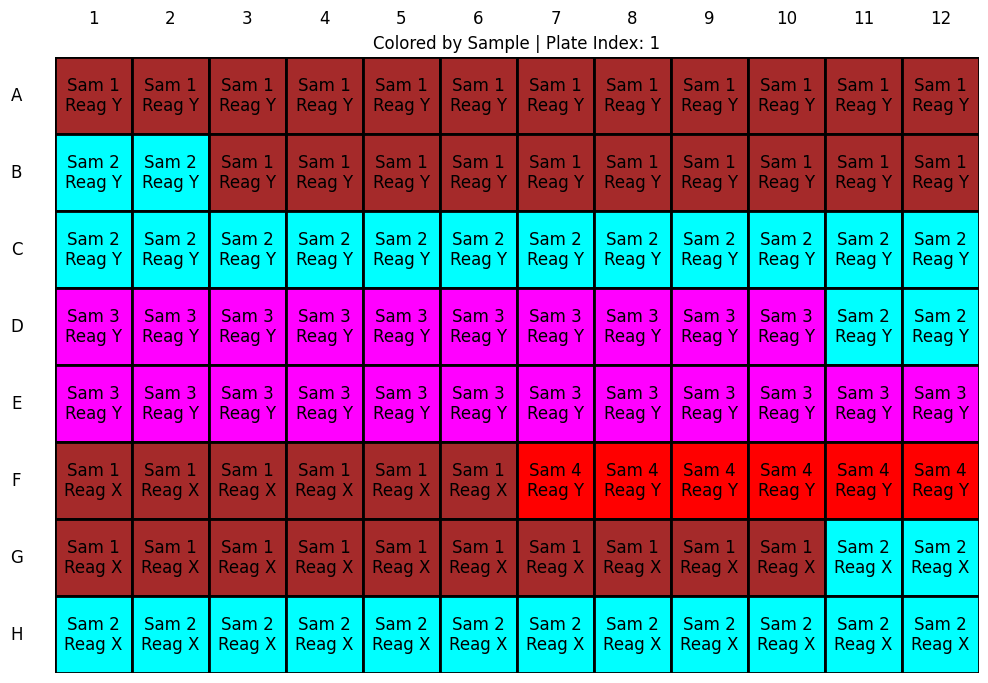

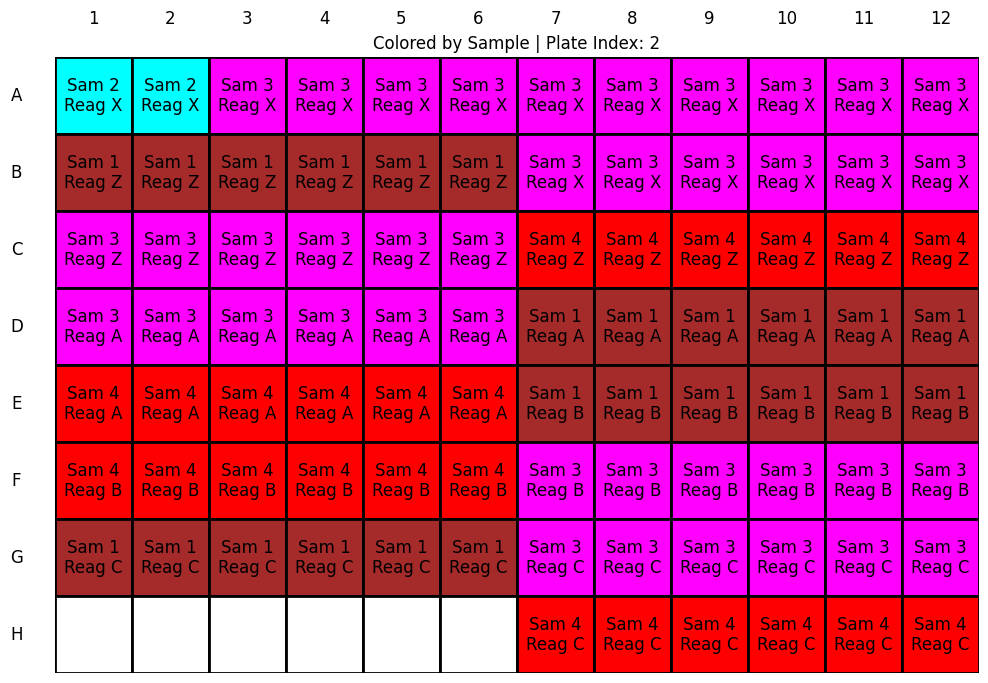

In [53]:
def sort_by_reagents_and_fill(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[List[List[str]]]:
    not_enough, wells_needed, wells_available = not_enough_plates(plate_size, samples, reagents, replicas, well_num)
    if not_enough:
        error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
        raise PlateFillError(error_message)
 
    if plate_size == 96:
        num_rows = 8
        num_cols = 12
    elif plate_size == 384:
        num_rows = 16
        num_cols = 24


    experiment_count = len(replicas)
    sample_per_reagent_counter = defaultdict(Counter)
    reagent_counter = Counter()

    for experiment_number in range(experiment_count):
        experiment_samples = samples[experiment_number]
        experiment_reagents = reagents[experiment_number]
        experiment_replicas = replicas[experiment_number]

        for reagent in experiment_reagents:
            for sample in experiment_samples:
                sample_per_reagent_counter[reagent][sample] += experiment_replicas
                reagent_counter[reagent] += experiment_replicas

    reagents_sorted_by_frequency = [key for key, _ in reagent_counter.most_common()]

    current_well = 0
    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
    result = []

    for reagent in reagents_sorted_by_frequency:
        samples_sorted_by_frequency= [(key, value)for key, value in sample_per_reagent_counter[reagent].most_common()]
        samples_sorted_by_name = sorted(samples_sorted_by_frequency)
        for sample, freq in samples_sorted_by_name:
            for i in range(freq):
                if current_well == plate_size:
                    flip_even_rows(plate)
                    result.append(plate)
                    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
                    current_well = 0

                row_index = current_well // num_cols
                col_index = current_well % num_cols

                plate[row_index][col_index] = [sample, reagent]

                current_well += 1
    
    if plate[0][0]:
        flip_even_rows(plate)
        result.append(plate)

    return result

try:
    plates = sort_by_reagents_and_fill(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}

for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='reagent', plate_index=i)
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='sample', plate_index=i)
    # plt.savefig(f'Plate_{i}.png')


Generally I'm pretty happy with the current implementation, however there seem to be some edge cases that make the current logic very inefficient. Let me demonstrate.

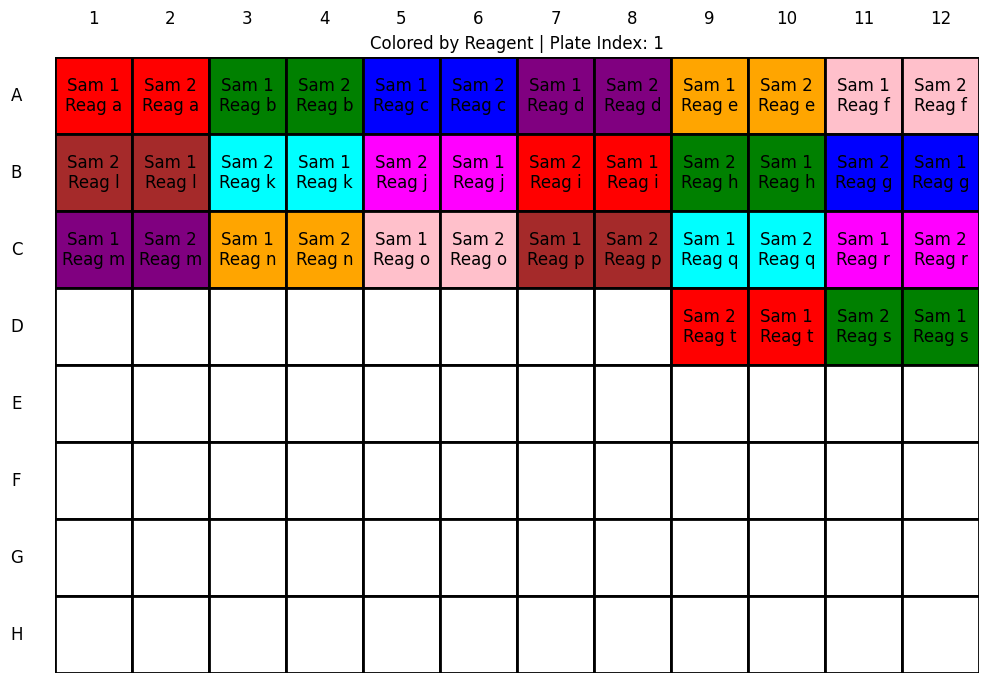

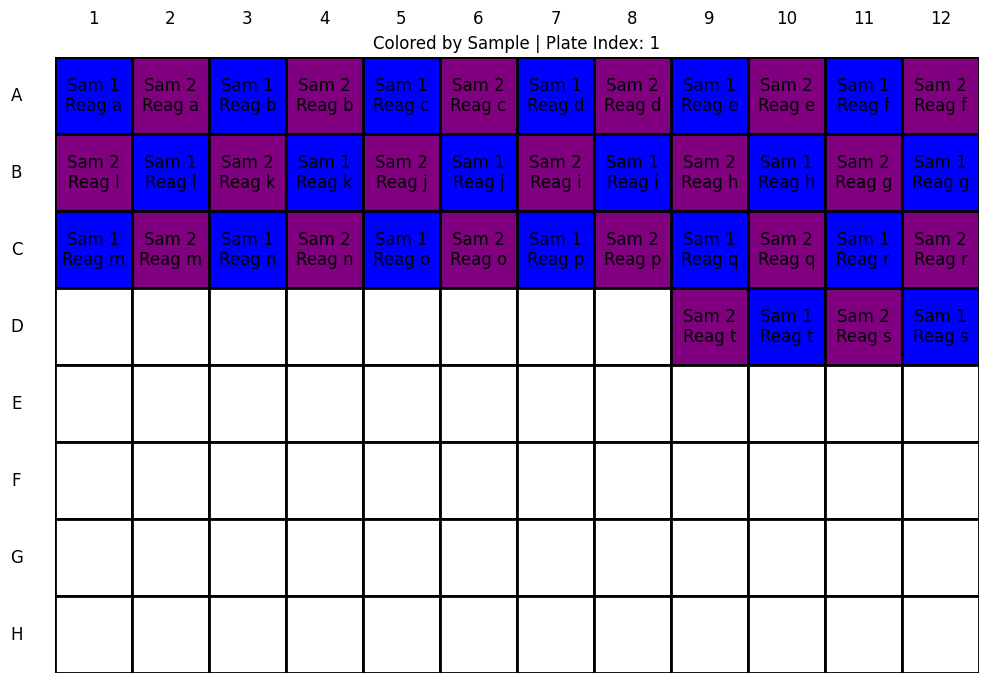

In [54]:
# Approach 2 with predefined edge case inputs
edge_samples = [['Sam 1', 'Sam 2']]
edge_reagents = [['Reag ' + chr(ord('a') + i) for i in range(20)]]
edge_replicas = [1]
try:
    plates = sort_by_reagents_and_fill(plate_size=plate_size, samples=edge_samples, reagents=edge_reagents, replicas=edge_replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}

for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='reagent', plate_index=i)
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='sample', plate_index=i)
    # plt.savefig(f'Plate_{i}.png')

When there are many different reagents and only a few samples it would make more sense to swap the grouping strategy.

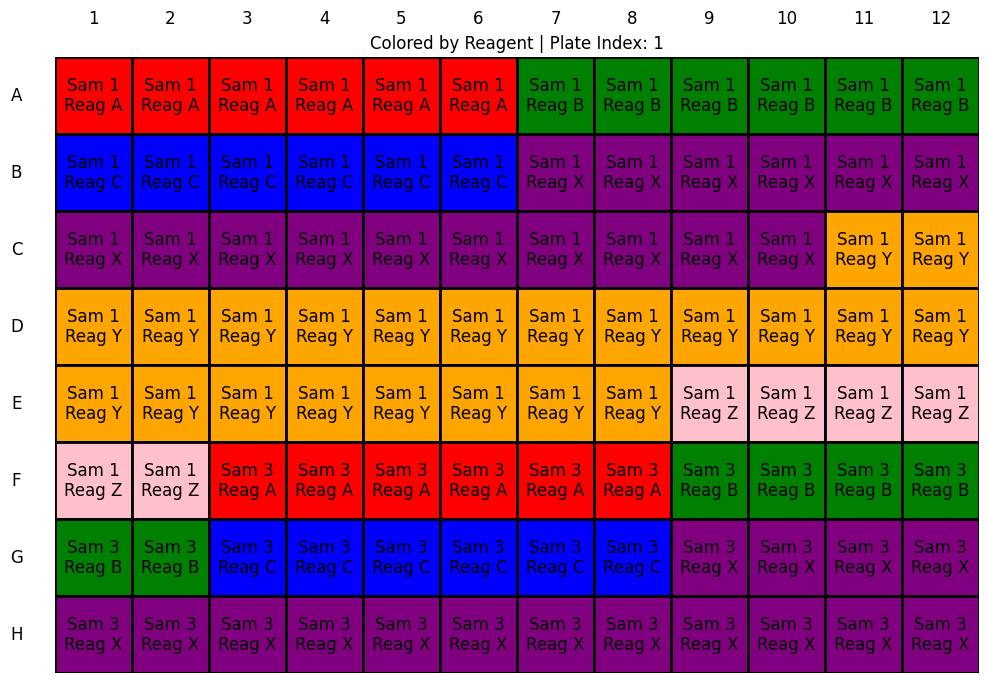

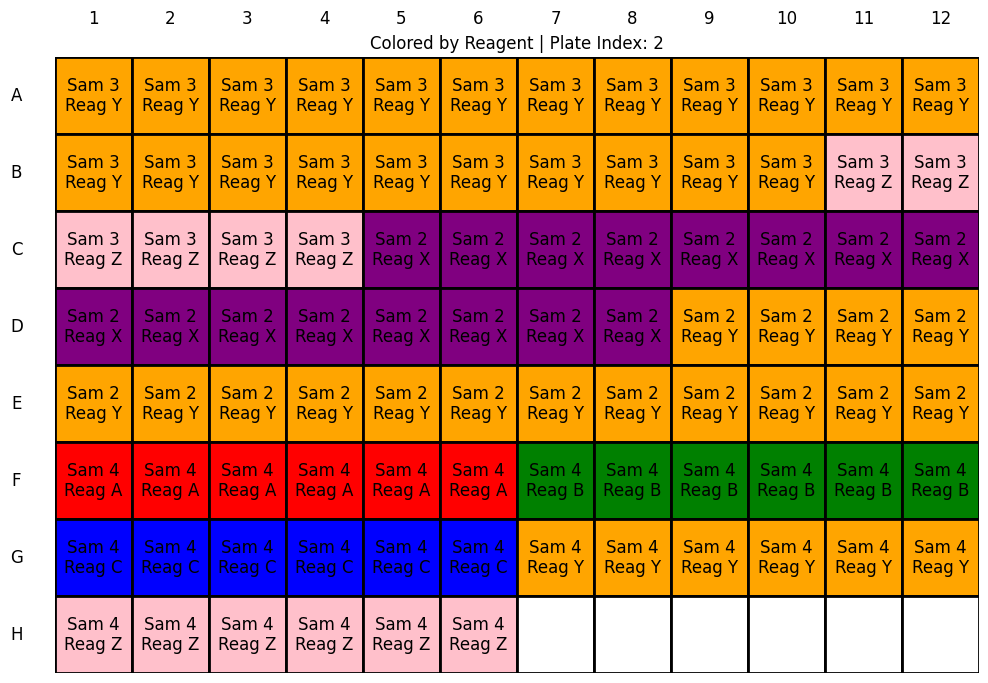

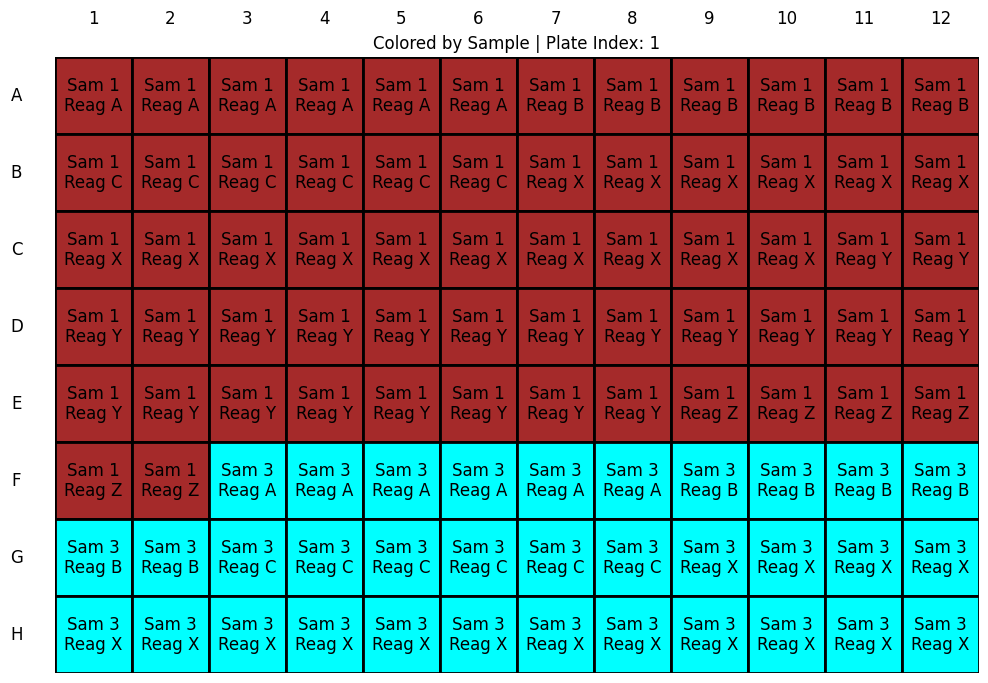

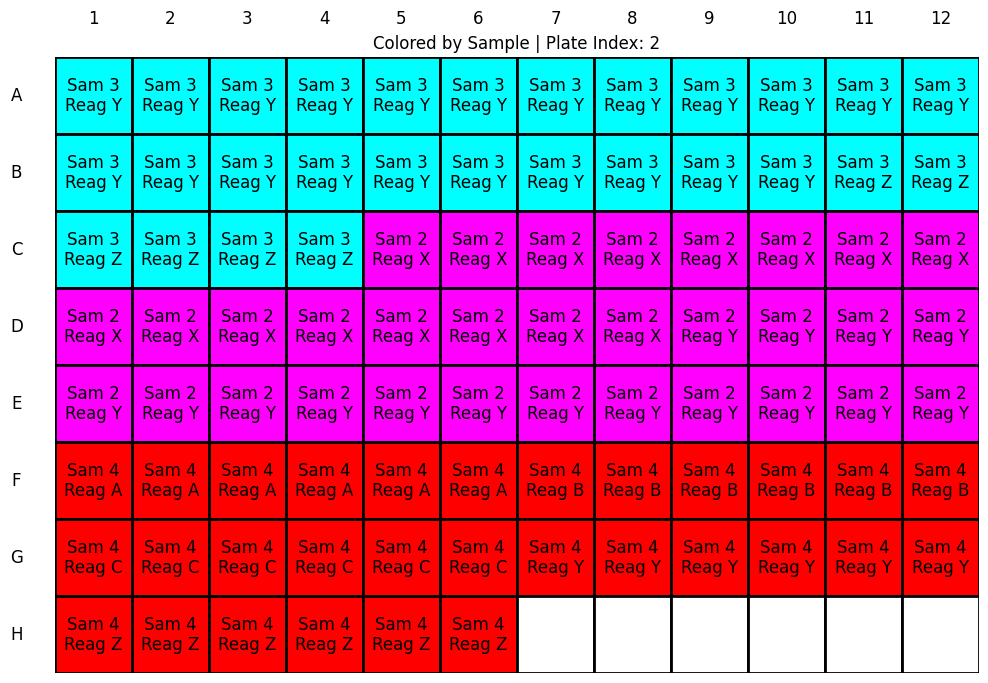

In [55]:
def sort_by_smaller_group_and_fill(plate_size: int, samples: List[List[str]], reagents: List[List[str]], replicas: List[int], well_num: int) -> List[List[List[str]]]:
    not_enough, wells_needed, wells_available = not_enough_plates(plate_size, samples, reagents, replicas, well_num)
    if not_enough:
        error_message = f"Number of wells needed {wells_needed} exceed available number of wells {wells_available}."
        raise PlateFillError(error_message)
 
    if plate_size == 96:
        num_rows = 8
        num_cols = 12
    elif plate_size == 384:
        num_rows = 16
        num_cols = 24

    experiment_count = len(replicas)
    sample_per_reagent_counter = defaultdict(Counter)
    reagent_per_sample_counter = defaultdict(Counter)
    reagent_counter = Counter()
    sample_counter = Counter()

    for experiment_number in range(experiment_count):
        experiment_samples = samples[experiment_number]
        experiment_reagents = reagents[experiment_number]
        experiment_replicas = replicas[experiment_number]

        for reagent in experiment_reagents:
            for sample in experiment_samples:
                sample_per_reagent_counter[reagent][sample] += experiment_replicas
                reagent_per_sample_counter[sample][reagent] += experiment_replicas
                sample_counter[sample] += experiment_replicas
                reagent_counter[reagent] += experiment_replicas

    reagents_sorted_by_frequency = [key for key, _ in reagent_counter.most_common()]

    current_well = 0
    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
    group_by_reagent_result = []

    for reagent in reagents_sorted_by_frequency:
        samples_sorted_by_frequency= [(key, value)for key, value in sample_per_reagent_counter[reagent].most_common()]
        samples_sorted_by_name = sorted(samples_sorted_by_frequency)
        for sample, freq in samples_sorted_by_name:
            for i in range(freq):
                if current_well == plate_size:
                    flip_even_rows(plate)
                    group_by_reagent_result.append(plate)
                    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
                    current_well = 0

                row_index = current_well // num_cols
                col_index = current_well % num_cols

                plate[row_index][col_index] = [sample, reagent]

                current_well += 1
    
    if plate[0][0]:
        flip_even_rows(plate)
        group_by_reagent_result.append(plate)

    
    samples_sorted_by_frequency = [key for key, _ in sample_counter.most_common()]

    current_well = 0
    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
    group_by_sample_result = []

    for sample in samples_sorted_by_frequency:
        reagents_sorted_by_frequency= [(key, value)for key, value in reagent_per_sample_counter[sample].most_common()]
        reagents_sorted_by_name = sorted(reagents_sorted_by_frequency)
        for reagent, freq in reagents_sorted_by_name:
            for i in range(freq):
                if current_well == plate_size:
                    flip_even_rows(plate)
                    group_by_sample_result.append(plate)
                    plate = [[[None] for _ in range(num_cols)] for _ in range(num_rows)]
                    current_well = 0

                row_index = current_well // num_cols
                col_index = current_well % num_cols

                plate[row_index][col_index] = [sample, reagent]

                current_well += 1

    

    if plate[0][0]:
        flip_even_rows(plate)
        group_by_sample_result.append(plate)

    return group_by_reagent_result if evaluate_microplate(group_by_sample_result) >= evaluate_microplate(group_by_reagent_result) else group_by_sample_result
    
try:
    plates = sort_by_smaller_group_and_fill(plate_size=plate_size, samples=samples, reagents=reagents, replicas=replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}

for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='reagent', plate_index=i)
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='sample', plate_index=i)
    # plt.savefig(f'Plate_{i}.png')


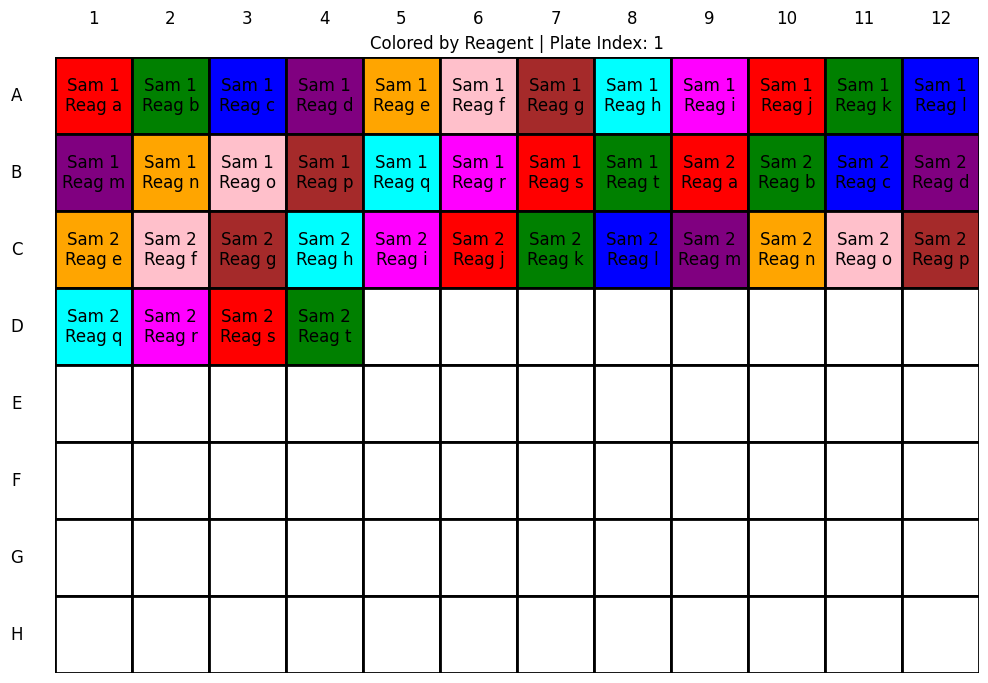

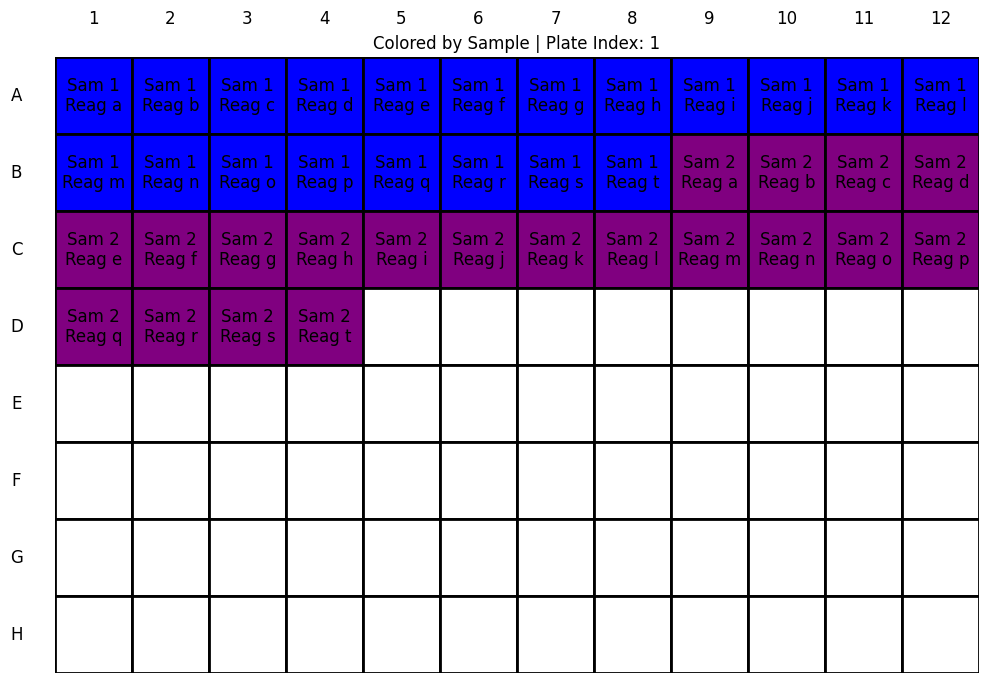

In [56]:
# Adjusted approach 2 with predefined edge case inputs
edge_samples = [['Sam 1', 'Sam 2']]
edge_reagents = [['Reag ' + chr(ord('a') + i) for i in range(20)]]
edge_replicas = [1]
try:
    plates = sort_by_smaller_group_and_fill(plate_size=plate_size, samples=edge_samples, reagents=edge_reagents, replicas=edge_replicas, well_num=well_num)
except PlateFillError as e:
    print(f"PlateFillError: {e.message}")


colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta']
color_cycle = itertools.cycle(colors)

color_map = {}

for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='reagent', plate_index=i)
for i, plate in enumerate(plates, 1):
    plot_plate(plate=plate, color_map=color_map, color_by='sample', plate_index=i)
    # plt.savefig(f'Plate_{i}.png')

